In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy
import sys
from matplotlib.path import Path
import emcee
import corner
import time

# Step 1. Analyse the DR2 data

In [2]:
def read_fits (name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data

In [3]:
dr2_data = np.genfromtxt('/home/pol/PhD_DATA/GDR2/47Tuc.dat', missing_values= "", filling_values= np.nan)
dr2_data = dr2_data.T
#dr2_data = read_fits('/home/pol/PhD_DATA/GDR2/47Tuc.fits')

In [4]:
# We need to remove the stars that don't have PM data.
print dr2_data.shape
bad_indeces = np.where(np.isnan(dr2_data[4]))
dr2_data = np.delete(dr2_data, bad_indeces, 1)
print dr2_data.shape

(14, 407331)
(14, 336424)


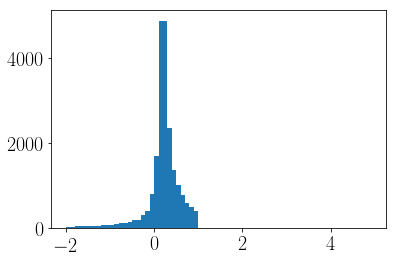

In [11]:
plt.hist(dr2_data[4], bins = np.arange(-2,5,0.1))
plt.show()

In [10]:
print dr2_data.shape

(14, 21540)


Let's remove stars that are within 1kpc from us first and see how it looks. It will remove some contamination that we might have.

In [9]:
bad_indeces = np.where(dr2_data[4] > 1)
dr2_data = np.delete(dr2_data, bad_indeces, 1)

In [62]:
print dr2_data.shape

(14, 17655)


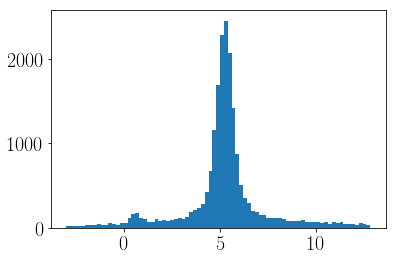

In [19]:
plt.hist(dr2_data[6], bins = np.arange(0,10,0.1))
plt.minorticks_on()
plt.show()

In [61]:
bad_indeces = np.where(dr2_data[6] > 10)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
bad_indeces = np.where(dr2_data[6] < 1)
dr2_data = np.delete(dr2_data, bad_indeces, 1)

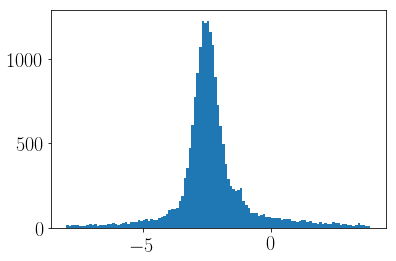

In [22]:
plt.hist(dr2_data[8], bins = np.arange(-8,4,0.1))
plt.show()

In [23]:
bad_indeces = np.where(dr2_data[8] > 4)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
bad_indeces = np.where(dr2_data[8] < -8)
dr2_data = np.delete(dr2_data, bad_indeces, 1)

In [24]:
print dr2_data.shape

(14, 19284)


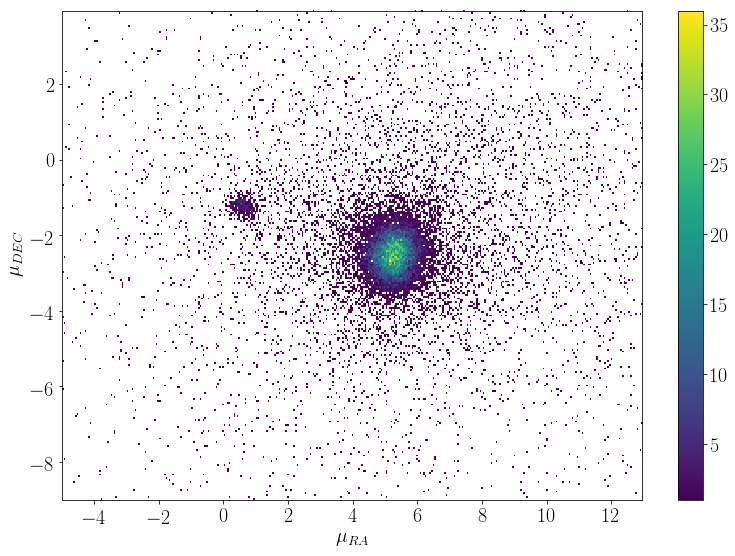

In [12]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
plt.figure(1, figsize=(13,9))
plt.hist2d(dr2_data[6], dr2_data[8], bins = [np.arange(-5,13,0.05), np.arange(-9,4,0.05)], cmin = 1)
plt.xlabel('$\mu _{RA}$')
plt.ylabel('$\mu _{DEC}$')
plt.colorbar()
plt.show()

# Intermediate step. Testing with double gaussian fitting

First, we create a model with two gaussians in one dimension

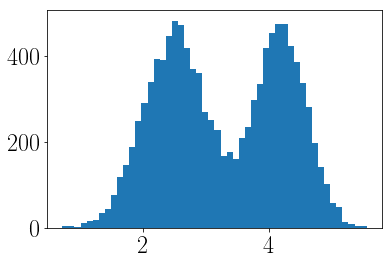

In [36]:
mean1 = 4.2
std1int = 0.4
std1obs = 0.1
size1 = 5000
obs_errors1 = np.random.normal(loc = 0.0, scale = std1obs, size = size1)

mean2 = 2.5
std2int = 0.5
std2obs = 0.1
size2 = 6000
obs_errors2 = np.random.normal(loc = 0.0, scale = std2obs, size = size2)

gaussian1 = np.random.normal(loc = mean1, scale = std1int, size = size1) + obs_errors1
gaussian2 = np.random.normal(loc = mean2, scale = std2int, size = size2) + obs_errors2
gaussians = np.concatenate((gaussian1, gaussian2))
obs_errors = np.concatenate((obs_errors1, obs_errors2))
#print gaussians.size
plt.hist(gaussians, bins = 50)
plt.show()

In [37]:
def lnlike(theta, x, xerr):
    p, mu1, sigma1, mu2, sigma2 = theta
    likelihood = p * (1.0/np.sqrt(2.0*np.pi*(sigma1**2 + xerr**2))) * np.exp((x-mu1)**2/(-2.0*(sigma1**2 + xerr**2))) \
    + (1.0-p) * (1.0/np.sqrt(2.0*np.pi*(sigma2**2 + xerr**2))) * np.exp((x-mu2)**2/(-2.0*(sigma2**2 + xerr**2)))
    return np.sum(np.log(likelihood))

In [38]:
def lnprior(theta):
    p, mu1, sigma1, mu2, sigma2 = theta
    if 0 < p < 1 and 3 < mu1 < 5 and 0 < sigma1 < 2 and 1 < mu2 < 3 and 0 < sigma2 < 2:
        return 0.0
    return -np.inf

In [39]:
def lnprob(theta, x, xerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, xerr)

In [40]:
ndim, nwalkers = 5, 100
init_pos = [[0.5, 4.0, 1.0, 2.0, 1.0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(gaussians, obs_errors))
number_iterations = 1000
sampler.run_mcmc(init_pos, number_iterations)

(array([[0.45462102, 4.20095918, 0.38784966, 2.51838081, 0.50372704],
        [0.45744808, 4.18480221, 0.39860589, 2.50484748, 0.49667232],
        [0.45065441, 4.18354713, 0.38910415, 2.50629869, 0.50177535],
        [0.45704223, 4.20762945, 0.39263391, 2.5087007 , 0.4863183 ],
        [0.44340591, 4.20728783, 0.38439599, 2.51330671, 0.50275745],
        [0.45202814, 4.20137343, 0.38338247, 2.51818244, 0.50203139],
        [0.45890009, 4.20374675, 0.38657343, 2.51783276, 0.49062224],
        [0.45177934, 4.19426269, 0.38686301, 2.50162464, 0.49757518],
        [0.44840472, 4.19541327, 0.3863182 , 2.51406254, 0.5007431 ],
        [0.4516837 , 4.19562605, 0.39234499, 2.50621666, 0.49500463],
        [0.45097932, 4.18969254, 0.39905294, 2.50531675, 0.49837978],
        [0.45171619, 4.20289858, 0.38547567, 2.52397424, 0.49570939],
        [0.45142951, 4.19674186, 0.37975338, 2.53440033, 0.49855369],
        [0.45779608, 4.19692263, 0.39392552, 2.50099139, 0.48386094],
        [0.45843986,

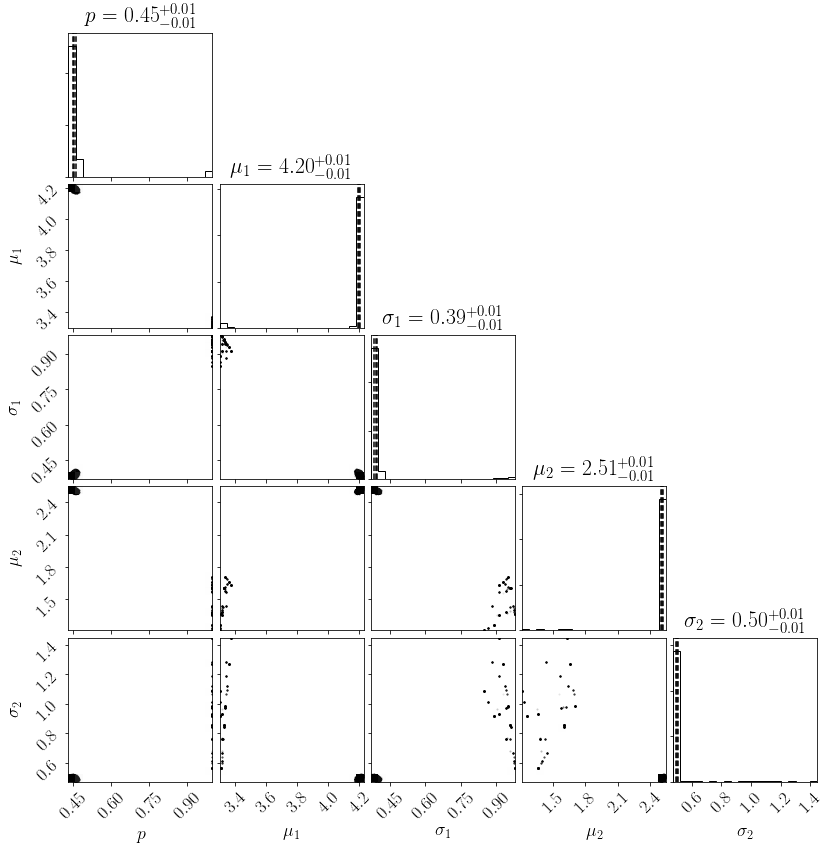

In [44]:
samples = sampler.chain[:, 700:, :].reshape((-1, ndim))
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["$p$", "$\mu_1$", "$\sigma_1$", "$\mu_2$", "$\sigma_2$"], quantiles = [0.16, 0.50, 0.84], show_titles=True)
fig.savefig("/home/pol/Documents/PhD/CMD_SMASH/Plots/test_emcee_double_gaussian_fitting.png")

# Step 2. Do some real fitting to the PM RA

In [13]:
def lnlike(theta, x, xerr):
    p, mu1, sigma1, mu2, sigma2 = theta
    likelihood = p * (1.0/np.sqrt(2.0*np.pi*(sigma1**2 + xerr**2))) * np.exp((x-mu1)**2/(-2.0*(sigma1**2 + xerr**2))) \
    + (1.0-p) * (1.0/np.sqrt(2.0*np.pi*(sigma2**2 + xerr**2))) * np.exp((x-mu2)**2/(-2.0*(sigma2**2 + xerr**2)))
    return np.sum(np.log(likelihood))

In [14]:
def lnprior(theta):
    p, mu1, sigma1, mu2, sigma2 = theta
    if 0 < p < 1 and -2 < mu1 < 3 and 0 < sigma1 < 2 and 3 < mu2 < 7 and 0 < sigma2 < 2.5:
        return 0.0
    return -np.inf

In [29]:
def lnprob(theta, x, xerr):
    lp = lnprior_1gaus(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_1gaus(theta, x, xerr)

In [63]:
def lnlike_1gaus(theta, x, xerr):
    mu, sigma, background = theta
    likelihood = (1.0/np.sqrt(2.0*np.pi*(sigma**2 + xerr**2))) * np.exp((x-mu)**2/(-2.0*(sigma**2 + xerr**2))) + background
    return np.sum(np.log(likelihood))

In [65]:
def lnprior_1gaus(theta):
    mu, sigma, background = theta
    if 2 < mu < 8 and 0 < sigma < 3 and 0 < background < 150:
        return 0.0
    return -np.inf

In [66]:
# For 1 gaussian
ndim, nwalkers = 3, 100
init_pos = [[5.0, 1.5, 80] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [16]:
# For 2 gaussians
ndim, nwalkers = 5, 100
init_pos = [[0.5, 2.0, 1.0, 5.0, 1.0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [67]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dr2_data[6], dr2_data[7]))
number_iterations = 4000
sampler.run_mcmc(init_pos, number_iterations)

(array([[5.35410384e+00, 7.21151292e-04, 1.49995281e+02],
        [5.32264605e+00, 1.74583779e-02, 1.49998213e+02],
        [5.28643513e+00, 3.76922414e-02, 1.49994958e+02],
        [5.24850671e+00, 2.69706320e-02, 1.49998744e+02],
        [5.18567277e+00, 7.13439935e-02, 1.49997325e+02],
        [5.21717216e+00, 4.40980009e-02, 1.49997505e+02],
        [5.29340142e+00, 4.37417409e-02, 1.49997054e+02],
        [5.17985336e+00, 1.34423996e-02, 1.49989641e+02],
        [5.23542348e+00, 1.02389124e-02, 1.49992452e+02],
        [5.35404348e+00, 3.01924669e-02, 1.49999100e+02],
        [5.15689806e+00, 6.52981309e-02, 1.49992552e+02],
        [5.22161914e+00, 3.79536097e-02, 1.49991309e+02],
        [5.22766415e+00, 9.19701127e-02, 1.49997246e+02],
        [5.26610964e+00, 8.68252054e-03, 1.49998801e+02],
        [5.20209600e+00, 3.17289954e-03, 1.49993961e+02],
        [5.19778501e+00, 1.75831442e-02, 1.49993760e+02],
        [5.33013827e+00, 1.17704669e-02, 1.49998575e+02],
        [5.186

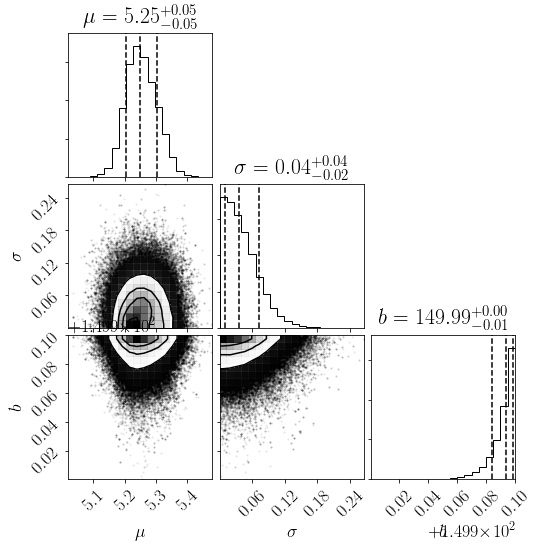

In [68]:
samples = sampler.chain[:, 300:, :].reshape((-1, ndim))
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["$\mu$", "$\sigma$", "$b$"], quantiles = [0.16, 0.50, 0.84], show_titles=True)
fig.savefig("/home/pol/Documents/PhD/CMD_SMASH/Plots/47tuc_pmra_double_gaussian_fitting.png")

In [57]:
mu_fit, sigma_fit = np.percentile(samples, 50, axis=0)
print mu_fit, sigma_fit

5.210129841815252 2.037255287033901


In [25]:
def double_gaussian(x, mean1, sigma1, mean2, sigma2, amplitude = 0.5):
    return amplitude * ( np.exp(-0.5 * (x-mean1)**2 / (sigma1**2)) / np.sqrt(2.0 * np.pi * sigma1**2) + \
    np.exp(-0.5 * (x-mean2)**2 / (sigma2**2)) / np.sqrt(2.0 * np.pi * sigma2**2) )

In [56]:
def one_gaussian(x, mean, sigma, amplitude = 1.0):
    return (amplitude * np.exp(-0.5 * (x-mean)**2 / (sigma**2))) / (np.sqrt(2.0 * np.pi * sigma**2))

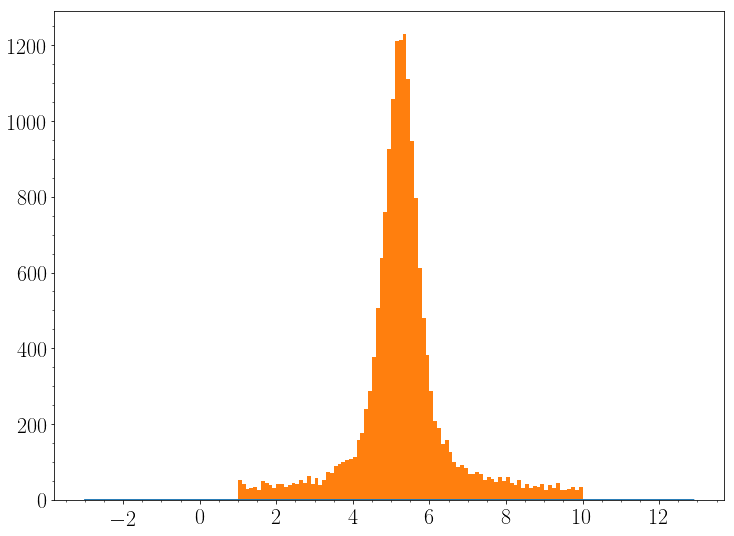

In [64]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,9))

x_values = np.arange(-3,13, 0.1)
fit_values = one_gaussian(x_values, mu_fit, sigma_fit)

plt.plot(x_values, fit_values)
plt.hist(dr2_data[6], bins = np.arange(1,10,0.1), density = True)
plt.minorticks_on()
plt.show()

Right, doesn't work. Let's see if we can imporve the determination of the proper motion of the cluster by doing more cuts on the data set based on colours and magnitudes.

# CMD cutting

87.0


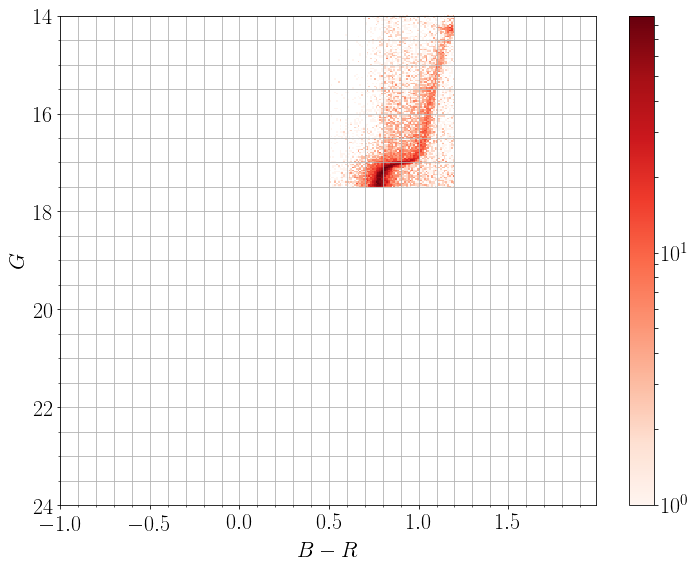

In [44]:
xbinsize = 0.01
ybinsize = 0.03
xbins = np.arange( start = -1, stop = 2, step = xbinsize)
ybins = np.arange( start = 14, stop = 24, step = ybinsize)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':22})
plt.figure(1, figsize=(12,9))

hist2d_data = np.histogram2d(dr2_data[12], dr2_data[11], bins = [xbins,ybins])
print(np.max(hist2d_data[0]))
plt.hist2d(dr2_data[12], dr2_data[11], bins = [xbins,ybins], cmap = 'Reds', cmin = 1, norm = matplotlib.colors.LogNorm())
plt.colorbar()

# Anotations for 47Tuc
#plt.annotate('NGC104 MS\n+ SMC RC', xy = (0.8,19.8), xycoords = 'data', xytext = (-0.5,17), arrowprops = dict(arrowstyle='->'))

# Annotations for NGC362
#plt.annotate('NGC362 MS\n+ SMC RGB', xy = (0.75,21.4), xycoords = 'data', xytext = (1.1,21.2), arrowprops = dict(arrowstyle='->'))

plt.gca().invert_yaxis()
plt.xlabel('$B-R$')
plt.ylabel('$G$')
plt.minorticks_on()
plt.grid(which='both')
#plt.title('Field 4')
plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_47Tuc_DR2_before_cleaning.pdf', bbox_inches='tight')
plt.show()

Well, shit, not much we can do here. Cuts in magnitude won't be very useful, so we can make a soft cut in colour.

In [5]:
bad_indeces = np.where(dr2_data[12] < 0.5)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
#bad_indeces = np.where(dr2_data[12] > 1.6)
#dr2_data = np.delete(dr2_data, bad_indeces, 1)
print dr2_data.shape

(14, 303721)


Alright, everything's pretty bad. Let's just try to see if we can get the PM parameters only for the cluster.

In [6]:
bad_indeces = np.where(dr2_data[11] > 17.5)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
bad_indeces = np.where(dr2_data[12] > 1.2)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
print dr2_data.shape

(14, 24177)


OK, so take home message is: do only one gaussian, whatever it takes.